In [1]:
%matplotlib qt6

import time

from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
from mavlink.mavlink import MAVLinkController, DataAcquisitionThread
from mavlink.mavlink.processor import DataProcessor, GimbalProcessor, GlobalPositionProcessor, AttitudeProcessor

import cv2


mavlink_connection = MAVLinkController("udp:0.0.0.0:14550")

attitude_processor = AttitudeProcessor()
global_position_processor = GlobalPositionProcessor()
gimbal_processor = GimbalProcessor()

acquisition_thread = DataAcquisitionThread(
    mavlink_connection, 
    [attitude_processor, global_position_processor, gimbal_processor]
)
acquisition_thread.start()

In [2]:
from data_stream import StreamReceiver

from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import RangefinderData, CameraData, FDMData, GimbalAxisData, GimbalData, DroneData
import cv2


host = "192.168.0.107"
port = 5588
stream_receiver = StreamReceiver(host, port)

In [4]:
import math

latest_data = gimbal_processor.get_data()
if latest_data:
    print("GIMBAL", [math.degrees(axis) for axis in latest_data.quaternion.to_euler()])


GIMBAL [3.385469632888878e-07, -30.62584173506847, -17.71234487953502]


In [45]:
mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=-35,
    yaw=-15
)

In [5]:
from matplotlib import pyplot as plt


data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

plt.imshow(camera_frame)

In [29]:
from ultralytics import YOLO
import random
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.deep.extractor import Extractor
from deep_sort.deep_sort.deep.configuration import ResNetConfiguration
from deep_sort.deep_sort.deep.weights import RESNET18_WEIGHTS


model = YOLO("yolov8n-visdrone.pt")

detection_threshold = 0.3

resnet = ResNetConfiguration(
    base="resnet18",
    weights_path=RESNET18_WEIGHTS,
    use_cuda=False
)
extractor = Extractor(model=resnet, batch_size=4)

tracker = Tracker(
    feature_extractor=extractor,
    max_iou_distance=1,
    max_cosine_distance=1
)

colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

In [30]:
for i in range(10):
    data = stream_receiver.get_data()
    drone_data = DroneData.from_json(data)
    camera_frame = drone_data.camera.frame
    
    result = model.predict(
        source=camera_frame,
        imgsz=camera_frame.shape[:2],
        classes=None,
        conf=0.3,
        iou=0.5,
        max_det=10,
        augment=False,
        agnostic_nms=True,
        device="cpu",
        half=False,
        verbose=False
    )[0]
    
    detections = []
    for result in result.boxes.data.tolist():    
        x1, y1, x2, y2, score, class_id = result
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        class_id = int(class_id)    
        
        detections.append([x1, y1, x2, y2, score, class_id])
        
    tracker.update(camera_frame, detections)
    
for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id

    print(
        x1, y1, x2, y2, track_id, class_id
    )
    
    color = colors[track_id % len(colors)]

    cv2.rectangle(
        camera_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )

    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    cv2.circle(
        camera_frame,
        (cx, cy),
        3,
        color,
        -1
    )

    cv2.putText(
        camera_frame,
        f"ID: {track_id}",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )

plt.imshow(camera_frame)

266.0468794471143 222.25333118183198 360.4013858173933 301.0163002084422 1 3
312.10348452601625 294.8301912551437 343.2524656869371 344.73217313942627 2 0


In [28]:
import geospatial as geo_utils


file_path = "S36E149.hgt"
geospatial = geo_utils.GEOSpatial(file_path)

In [53]:
data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

image_width = drone_data.camera.width
image_height = drone_data.camera.height

fov_horizontal = drone_data.camera.fov
fov_vertical = 2 * math.atan(math.tan(fov_horizontal / 2) * (image_height / image_width))

gimbal_roll, gimbal_pitch, gimbal_yaw = gimbal_processor.get_data().quaternion.to_euler()
attitude = attitude_processor.get_data()

drone_roll = math.radians(attitude.roll)
drone_pitch = math.radians(attitude.pitch) 

global_position = global_position_processor.get_data()
drone_heading = math.radians(global_position.heading)

view_roll = gimbal_roll + drone_roll
view_pitch = gimbal_pitch + drone_pitch
view_yaw = gimbal_yaw + drone_heading

In [50]:
for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id
    
    # if model.names[class_id] == "car":
    if track_id == 1:
        detection_offset = geo_utils.detection_angles(geo_utils.find_center(x1, y1, x2, y2), (image_width, image_height), fov_horizontal, fov_vertical)
        
        direction_vector = geo_utils.calculate_direction_vector((view_roll, view_pitch, view_yaw), detection_offset)
    
        target_location = geo_utils.find_target_location(global_position, direction_vector)
        
        print(target_location)
    

(-35.36310847626477, 149.1651361293362, 585)


In [51]:
mavlink_connection.gimbal.set_roi_location(*target_location)

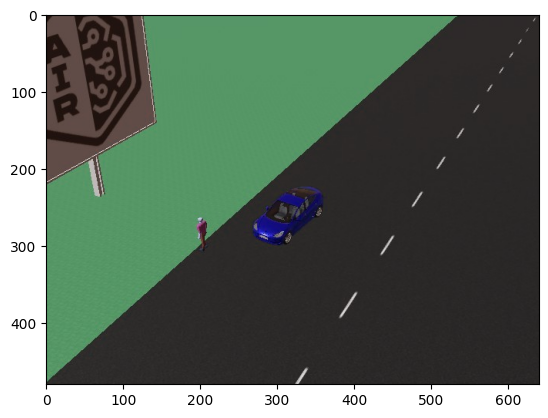

In [52]:
data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

plt.imshow(camera_frame)